In [1]:
using HierarchicalDriving
import POMDPs:initial_state
using POMDPToolbox
using Interact
using MCTS
using AutoViz
import ParticleFilters: obs_weight
import Base: ==, +, *, -, <, >, copy, Random, hash

In [8]:
HORIZON = 10
TIME_STEP = 0.3
lb_x = 0 #(AVG_HWY_VELOCITY - 5.0) * TIME_STEP * HORIZON
ub_x = 150 #(AVG_HWY_VELOCITY + 5.0) * TIME_STEP * HORIZON
p = LowLevelMDP(0.99,TIME_STEP, HORIZON,
                            HierarchicalDriving.RoadSegment((-100.0, 500.0),[0.0, LANE_WIDTH, 2.0 * LANE_WIDTH, 3.0 * LANE_WIDTH, 4.0 * LANE_WIDTH]),
                            CarPhysicalState((0.0, 3.0 * LANE_WIDTH/2.0, AVG_HWY_VELOCITY)),
                            (CarPhysicalState((lb_x, 5.0 * LANE_WIDTH/2.0 - 0.5, AVG_HWY_VELOCITY - 5)),
                             CarPhysicalState((ub_x, 5.0 * LANE_WIDTH/2.0 + 0.5, AVG_HWY_VELOCITY + 5))),
                            50.0, -500.0, -1.0, -5.0, -5.0, -1.0, HierarchicalDriving.getFrameList());

In [9]:
function testing()
    n = 100
    sum = 0.0
    sum1 = 0.0
    numPositiveRnd = 0
    numPositiveMCTS = 0
    for i in 1:n
        #policy = RandomPolicy(p)
        policy = subintentional_lowlevel_policy(p)
        hr = HistoryRecorder(max_steps = p.HORIZON, rng = MersenneTwister(i))
        hist = simulate(hr, p, policy)
        finState = state_hist(hist)[end]

        solver = DPWSolver(depth=p.HORIZON,
                             exploration_constant=10.0,
                             n_iterations=1_000,
                             k_action=10.0,
                             alpha_action=1/10,
                             k_state=5.0,
                             alpha_state=1/10,
                             estimate_value=RolloutEstimator(subintentional_lowlevel_policy(p))
                              )
        policy1 = solve(solver, p)
        hr1 = HistoryRecorder(max_steps = p.HORIZON, rng = MersenneTwister(i))
        hist1 = simulate(hr1, p, policy1)
        finState1 = state_hist(hist1)[end]
        

        println(i, ",", discounted_reward(hist), ",", discounted_reward(hist1))
        sum += discounted_reward(hist)
        sum1+= discounted_reward(hist1)
        if finState.terminal == 2 || HierarchicalDriving.checkTargetCoordinates(finState,p)
            numPositiveRnd += 1
        end
        if finState1.terminal == 2 || HierarchicalDriving.checkTargetCoordinates(finState1,p)
            numPositiveMCTS += 1
        end
    end
    println("Mean: ",sum/n,",", sum1/n)
    println("Success Rate: ", numPositiveRnd/n, ",", numPositiveMCTS/n)
end

testing (generic function with 1 method)

 in module Main at In[6]:2 overwritten at In[9]:2.


In [10]:
@time testing()

1,0.0,0.0
2,-1.4417803659219204,44.24325908291367
3,0.0,-1.1627255931506546
4,44.99354965496276,44.93818497329708
5,0.0,-5.929367445013061
6,44.99354965496276,44.99354965496276
7,44.99354965496276,44.93873862011374
8,44.99354965496276,44.99354965496276
9,0.0,0.0
10,0.0,-11.48239397820663
11,0.0,-0.3426331045470551
12,-1.4417803659219204,44.24325908291367
13,0.0,0.0
14,0.0,39.46967708291367
15,44.99354965496276,44.99354965496276
16,0.0,0.0
17,0.0,39.59787708291367
18,44.99354965496276,44.93818497329708
19,44.99354965496276,44.93818497329708
20,44.99354965496276,44.93762573408834
21,0.0,44.59787708291367
22,-1.7303989782066285,44.99354965496276
23,44.99354965496276,44.93762573408834
24,0.0,43.47080144691974
25,44.99354965496276,44.99354965496276
26,0.0,43.29438344691973
27,0.0,44.93873862011374
28,44.99354965496276,44.93762573408834
29,0.0,-10.796254798637655
30,0.0,39.25616123658505
31,0.0,34.25616123658505
32,0.0,-2.0744844689886284
33,-4.090549949524554,39.543066048064645
34,0.0,43.64

Interact.Options{:SelectionSlider,Int64}(Signal{Int64}(8, nactions=1),"i",8,"8",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…),Dict(2=>"2",16=>"16",11=>"11",7=>"7",9=>"9",10=>"10",8=>"8",6=>"6",4=>"4",3=>"3"…)),Any[],Any[],true,"horizontal")

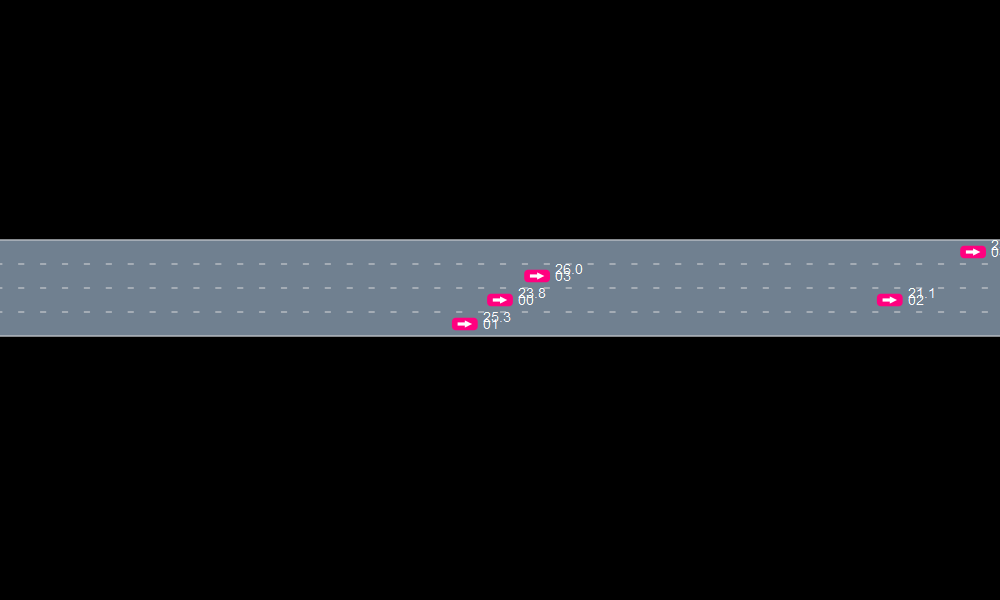

In [7]:
i = 87
#policy = RandomPolicy(p)
policy = subintentional_lowlevel_policy(p);
hr = HistoryRecorder(max_steps = p.HORIZON, rng = MersenneTwister(i));
hist = simulate(hr, p, policy);
#for stepno in 1:n_steps(hist)
    #act = action(policy, state_hist(hist)[stepno])
    #println("StepNo $stepno")
    #println(act)
    #println(action(policy, state_hist(hist)[stepno]))
#end
@manipulate for i in 1:n_steps(hist)+1
    (p,state_hist(hist)[i],SceneOverlay[CarVelOverlay(), CarIDOverlay()])
end

Interact.Options{:SelectionSlider,Int64}(Signal{Int64}(8, nactions=1),"i",8,"8",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…),Dict(2=>"2",16=>"16",11=>"11",7=>"7",9=>"9",10=>"10",8=>"8",6=>"6",4=>"4",3=>"3"…)),Any[],Any[],true,"horizontal")

8.173210 seconds (90.21 M allocations: 2.621 GB, 10.63% gc time)


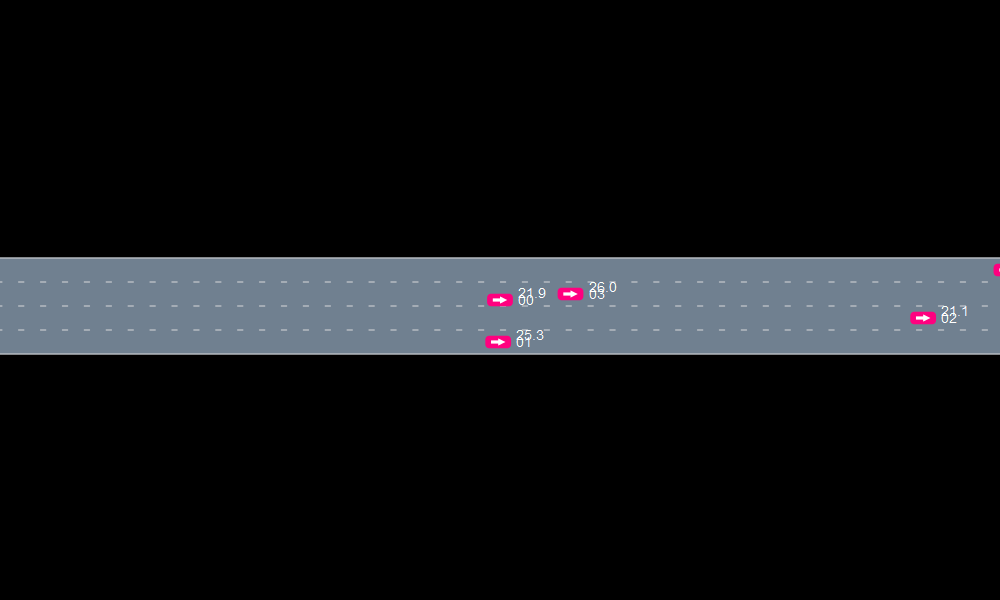

In [8]:
solver = DPWSolver(depth=p.HORIZON,
                             exploration_constant=10.0,
                             n_iterations=1_000,
                             k_action=10.0,
                             alpha_action=1/10,
                             k_state=5.0,
                             alpha_state=1/10,
                             estimate_value=RolloutEstimator(subintentional_lowlevel_policy(p))
                          )
policy1 = solve(solver, p)
hr1 = HistoryRecorder(max_steps = p.HORIZON, rng = MersenneTwister(i))
hr2 = HistoryRecorder(max_steps = p.HORIZON, rng = MersenneTwister(i))
@time (hist1 = simulate(hr1, p, policy1);)
#@time (hist2 = simulate(hr2, p, policy1);)
#for i in 1:n_steps(hist1)
#    println("StepNo $i")
#   @time (act = action(policy1, state_hist(hist1)[i]))
#    
#    println(act) 
#    println(action(policy, state_hist(hist)[i]))
#end
@manipulate for i in 1:n_steps(hist1)+1
    (p,state_hist(hist1)[i])
end

In [5]:
sh = state_hist(hist1)[end]
println(sh.ego)

HierarchicalDriving.CarPhysicalState((64.31508314322822,10.199999999999998,26.36390749962482))


In [6]:
discounted_reward(hist)

0.0

In [6]:
discounted_reward(hist1)

34.123558845652454